# Predicting clients' churn for telecom provider

## Introduction

**Target of analysis** - predict clients' churn for telecom provider by using machine learning. The model should predict whether client is going to leave or not. Services are provided by telecom operator: landline, internet and additional services, like streaming tv.

Model's target metric: ROC-AUC should be at least 0.85.

*Table of contents:*
- [data collection](#familiar)
- [data preprocessing](#preprocess)
- [data merge](#merge)
- [exploratory data analysis](#analysis)
- [feature engineering](#preparation)
- [models selection, training and evaluation](#learning)
- [testing model](#testing)
- [summary](#conclusion)

In [6]:
import os
import phik
import re
import shap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline
from lightgbm import LGBMClassifier
from phik import report
from phik.report import plot_correlation_matrix
from skimpy import clean_columns
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (RocCurveDisplay, balanced_accuracy_score,
                             confusion_matrix, recall_score,
                             roc_auc_score, roc_curve)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

In [7]:
RANDOM_STATE = 150324
TEST_SIZE = 0.25
np.random.seed(1)

<a id='familiar'></a>

## 1. Data collection

Start with importing data and defining customer's ID as an index. Then proceed by studying main information about each data frame.

In [14]:
data_contract.name = 'Information about contracts'
data_personal.name = 'Clients\' personal data'
data_internet.name = 'Information about internet services'
data_phone.name = 'Information about phone services'

In [15]:
datasets = [data_contract, data_personal, data_internet, data_phone]
for data in datasets:
    print('\n\n', data.name, '\n')
    data.info()



 Information about contracts 

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


 Clients' personal data 

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen 

The data frames provide information about approximately 7 thousand clients and their contracts, and we could see that clients use not all services at once. Further we would merge data frames with customer's ID as a common feature for all data frames. At first glance, there are no missing values, however many columns have an object data type, so it could be possible that missing values are hidden behind other values. The target would be created based on the `EndDate` column. Not all features would be necessary at the stage of training models. We could also notice that features are named not in accordance with PEP8.

Continue by taking a look at the first 5 lines of each data frame.

In [17]:
for data in datasets:
    print('\n\n', data.name)
    display(data.head())



 Information about contracts


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5




 Clients' personal data


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No




 Information about internet services


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No




 Information about phone services


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


The data type of some features doesn't correspond to the type of stored information, for example, type of `TotalCharges` feature is object, although it should be float type. Categorical features should be further encoded before training models. A scaling may also be required for quantitative characteristics - `MonthlyCharges` and `TotalCharges`.

We should check data period.

In [19]:
data_contract['BeginDate'].min()

Timestamp('2013-10-01 00:00:00')

Since we know that data was downloaded on 2020-02-01, we could conclude that overall data period is 6+ years.

**Intermediate conclusion:** 4 data frames contain anonymized customer and services data for over a period of 6 years. Number of objects in data frames varies from 5500 to 7000, indicating that clients utilize services on a selective basis. Notably, the operator's fundamental service — phone service with a single line — is absent in data frames and needs to be incorporated as an additional feature. Additionally, we would assess features' necessity before training each model. The `customerID` feature has been designated as the index and would serve as a basis for merging data frames. To facilitate our analysis we would create the target variable based on the `EndDate` column.

<a id='preprocess'></a>

## 2. Data preprocessing

### 2.1 Refining style

We should adjust headers' and index style.

In [26]:
for data in datasets:
    data.columns = [re.sub(r'([a-z])([A-Z])', r'\1_\2', col).lower() for col in data.columns]
    data.rename_axis('customer_id', inplace=True)

In [27]:
for i, data in enumerate(datasets):
    print('\n', data.name)
    display(data.columns)


 Information about contracts


Index(['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges'],
      dtype='object')


 Clients' personal data


Index(['gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')


 Information about internet services


Index(['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')


 Information about phone services


Index(['multiple_lines'], dtype='object')

Correction was completed successfully.

### 2.2 Checking for duplicates

Proceed by checking for explicit duplicates based on index, since combination of other features could be repeating in such large data volume.

In [31]:
for data in datasets:
    print(f'{data.name}: \n'
          f'All ids are unique - {data.index.is_unique} \n')

Information about contracts: 
All ids are unique - True 

Clients' personal data: 
All ids are unique - True 

Information about internet services: 
All ids are unique - True 

Information about phone services: 
All ids are unique - True 



Since there are no explicit duplicates, we would check for implicit duplicates based on unique values.

In [33]:
def unique_values(df, columns):
    """Check for implicit duplicates."""
    print(f'Data frame {df.name}')
    for col in columns:
        print(f'Unique values {col}: {df[col].unique()}')
    print('\n')

In [34]:
unique_values(data_contract, ['type', 'paperless_billing', 'payment_method'])
unique_values(data_personal, ['gender', 'senior_citizen', 'partner', 'dependents'])
unique_values(data_internet, ['internet_service', 'online_security', 'online_backup',
                              'device_protection', 'tech_support', 'streaming_tv',
                              'streaming_movies'])
unique_values(data_phone, ['multiple_lines'])

Data frame Information about contracts
Unique values type: ['Month-to-month' 'One year' 'Two year']
Unique values paperless_billing: ['Yes' 'No']
Unique values payment_method: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


Data frame Clients' personal data
Unique values gender: ['Female' 'Male']
Unique values senior_citizen: [0 1]
Unique values partner: ['Yes' 'No']
Unique values dependents: ['No' 'Yes']


Data frame Information about internet services
Unique values internet_service: ['DSL' 'Fiber optic']
Unique values online_security: ['No' 'Yes']
Unique values online_backup: ['Yes' 'No']
Unique values device_protection: ['No' 'Yes']
Unique values tech_support: ['No' 'Yes']
Unique values streaming_tv: ['No' 'Yes']
Unique values streaming_movies: ['No' 'Yes']


Data frame Information about phone services
Unique values multiple_lines: ['No' 'Yes']




There are no implicit duplicates as well.

### 2.3 Handling missing values

We should also check for missing values in columns `monthly_charges` and `total_charges`.

In [38]:
data_contract['monthly_charges'].sort_values().unique()

array([ 18.25,  18.4 ,  18.55, ..., 118.6 , 118.65, 118.75])

In [39]:
data_contract['total_charges'].sort_values().unique()

array([' ', '100.17', '100.19', ..., '998.89', '999.6', '999.9'],
      dtype=object)

There are implicit missing values in column `total_charges`.

In [41]:
data_contract.query('total_charges == " "')

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,


It appears that missing values are common among new clients who signed contracts on the same date as the data was downloaded. We would fill in the corresponding data from column `monthly_charges`.

In [43]:
data_contract.loc[data_contract['total_charges'] == ' ', 'total_charges'] = data_contract['monthly_charges']
data_contract.query('total_charges == " "')

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,


We successfully got rid of implicit missing values.

### 2.4 Changing data type

Proceed by adjusting data type.

In [47]:
data_contract['end_date'].sort_values().unique()

array(['2014-06-01', '2014-09-01', '2014-10-01', '2014-11-01',
       '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
       '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
       '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
       '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
       '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
       '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
       '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
       '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
       '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
       '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
       '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
       '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
       '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
       '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
       '2019-08-01', '2019-09-01', '2019-10-01', '2019-

We could notice there are no clients who churned on the date 2020-02-01. We would change value 'No' in `end_date` with 2020-02-01.

In [49]:
data_contract.loc[data_contract['end_date'] == 'No', 'end_date'] = '2020-02-01'

We should change data type for `total_charges` and `monthly_charges` and round up values, since digits after comma would not have great impact in this case.

In [51]:
data_contract['total_charges'] = round(data_contract['total_charges'].astype(float), 0).astype(int)
data_contract['monthly_charges'] = round(data_contract['monthly_charges'].astype(float), 0).astype(int)
data_contract['end_date'] = pd.to_datetime(data_contract['end_date'], yearfirst=True)

In [52]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   int64         
 6   total_charges      7043 non-null   int64         
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 698.2+ KB


Data type has been successfully changed.

### 2.5 Adding target

Proceed by adding a target named `outflow`, indicating client's status.

In [56]:
data_contract['outflow'] = np.where(data_contract['end_date'] == '2020-02-01', 0, 1)
data_contract.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,outflow
customer_id,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,30,31,0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,57,2072,0
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,54,226,0
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42,1961,0
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,71,354,0


We would also add a new feature `duration`, indicating amount of days in suscription period. Features `begin_date` and `end_date` should be removed in order to prevent target leakage.

In [58]:
data_contract['duration'] =\
    data_contract['end_date'].dt.to_period('D').astype(int) - data_contract['begin_date'].dt.to_period('D').astype(int)

In [59]:
data_contract.drop(columns=['begin_date', 'end_date'], inplace=True)
data_contract.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,outflow,duration
customer_id,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,30,31,0,31
5575-GNVDE,One year,No,Mailed check,57,2072,0,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,54,226,0,123
7795-CFOCW,One year,No,Bank transfer (automatic),42,1961,0,1371
9237-HQITU,Month-to-month,Yes,Electronic check,71,354,0,153


**Intermediate conclusion:** during data preprocessing stage we aligned feature names with the PEP8 naming convention, handled both explicit and implicit duplicates, implicit missing values. Additionally, data types were adjusted to align with stored information, and the target variable was created in the dataset.

<a id='merge'></a>

## 3. Data merge

We need to merge data frames based on customer's unique ID.

In [64]:
data = data_contract.join([data_personal, data_internet, data_phone])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   type               7043 non-null   object
 1   paperless_billing  7043 non-null   object
 2   payment_method     7043 non-null   object
 3   monthly_charges    7043 non-null   int64 
 4   total_charges      7043 non-null   int64 
 5   outflow            7043 non-null   int64 
 6   duration           7043 non-null   int64 
 7   gender             7043 non-null   object
 8   senior_citizen     7043 non-null   int64 
 9   partner            7043 non-null   object
 10  dependents         7043 non-null   object
 11  internet_service   5517 non-null   object
 12  online_security    5517 non-null   object
 13  online_backup      5517 non-null   object
 14  device_protection  5517 non-null   object
 15  tech_support       5517 non-null   object
 16  streaming_tv       5517 non-null

Proceed by taking a look on missing values in the new data frame.

In [66]:
nan_columns = data.isna().sum().sort_values(ascending=False)
nan_columns = nan_columns[nan_columns != 0]
percentage_missed = nan_columns/len(data) * 100
display(
    pd.DataFrame(
        {
            'Feature': nan_columns.index,
            'Amount of missing values': nan_columns.values,
            'Missing values rate, %': np.round(percentage_missed.values, 2)
        }
    )
)

,Feature,Amount of missing values,"Missing values rate, %"
0,streaming_movies,1526,21.67
1,streaming_tv,1526,21.67
2,tech_support,1526,21.67
3,device_protection,1526,21.67
4,online_backup,1526,21.67
5,online_security,1526,21.67
6,internet_service,1526,21.67
7,multiple_lines,682,9.68


As a result of merging data frames, NaN values have been appeared when client doesn't use particular services. We would create a new feature called `services`, defining a group of services used by client - internet or phone, or both of them.

In [68]:
data.loc[data['multiple_lines'].isna(), 'services'] = 'Internet'
data['multiple_lines'] = data['multiple_lines'].fillna('No')

In [69]:
data.loc[data['internet_service'].isna(), 'services'] = 'Landline'
data['internet_service'] = data['internet_service'].fillna('No internet')

In [70]:
data.loc[data['services'].isna(), 'services'] = 'Landline and internet'

In [71]:
data = data.fillna('No')

In [72]:
data.isna().any().any()

False

All missing values were successfully handled.

**Intermediate conclusion:** data merge resulted in new amount of missing values, particularly when clients don't utilize specific services. We addressed all missing values and introduced new feature indicating whether the client uses basic services such as internet, phone, or a combination of both.

<a id='analysis'></a>

## 4. Exploratory data analysis

### 4.1 General analysis of data frame

Continue by studying costs' main characteristics.

In [79]:
data[['monthly_charges','total_charges']].describe()

,monthly_charges,total_charges
count,7043.000000,7043.000000
mean,64.758768,2115.384495
std,30.091650,2112.679021
min,18.000000,19.000000
25%,36.000000,436.500000
50%,70.000000,1343.000000
75%,90.000000,3236.500000
max,119.000000,9221.000000


Monthly charges are distributed fairly evenly across all quartiles, and mean is slightly less than median. Total charges data is shifted closer to zero, which may be caused by different service's duration.

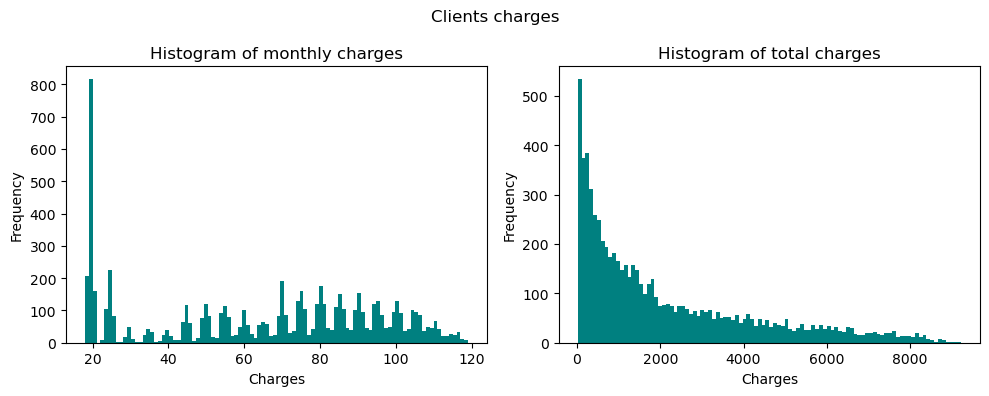

In [81]:
plot_params = {
    'xlabel': 'Charges',
    'ylabel': 'Frequency',
    'color': 'teal',
    'bins': 100
}

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Clients charges', fontsize=12)
data['monthly_charges'].plot(ax=axes[0], kind='hist', **plot_params)
axes[0].set_title('Histogram of monthly charges')

data['total_charges'].plot(ax=axes[1], kind='hist', **plot_params)
axes[1].set_title('Histogram of total charges')
plt.tight_layout();

Most monthly expenses are concentrated around mark equals to 20; there are probably many customers using one service (or set of services) in that price range. The histogram of total expenses has the form of an exponential distribution with peak of expenses till 200.

Continue by taking a look how much income the telecom provider receives from churned clients.

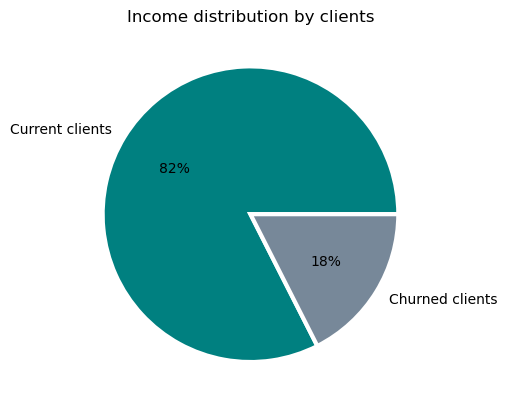

In [83]:
(data.groupby('outflow')['total_charges']
 .agg('sum')
 .plot(
     kind='pie',
     labels=['Current clients', 'Churned clients'],
     autopct='%1.0f%%',
     wedgeprops={'linewidth': 3, 'edgecolor': 'white'},
     colors=['teal', 'lightslategrey', 'sandybrown', 'mediumseagreen', 'skyblue', 'lightpink', 'olivedrab'],
     title='Income distribution by clients',
     ylabel=''
 )
);

Churned customers make around 18% of operator’s revenue. This is quite big percentage that should be tried to reduce by using predictions from machine learning models.

For the convenience of further analysis we would create a temporary column with grouped subscription period.

In [85]:
bins = [0, 31, 181, 366, 732, 1098, 1464, float('inf')]
labels = ['1 month', '6 months', '1 year', '2 years', '3 years', '4 years', '5+ years']

data['period'] = pd.cut(data['duration'], bins=bins, labels=labels)
data.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'outflow', 'duration', 'gender', 'senior_citizen',
       'partner', 'dependents', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines', 'services', 'period'],
      dtype='object')

Temporary feature was successfully created. Proceed by drawing a plot based on that column.

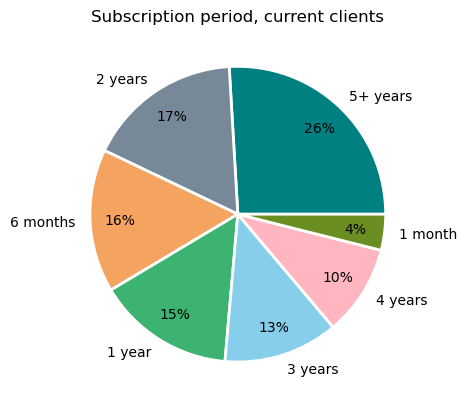

In [87]:
(data[data['outflow']==0]['period']
 .value_counts()
 .plot(
     kind='pie',
     autopct='%1.0f%%',
     pctdistance=0.8,
     wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
     colors=['teal', 'lightslategrey', 'sandybrown', 'mediumseagreen', 'skyblue', 'lightpink', 'olivedrab'],
     title='Subscription period, current clients',
     ylabel=''
 )
);

Most of current customers are served in the company with up to 1 year, next go customers with suscription period of more than 5 years.

Proceed by looking into services used by customers.

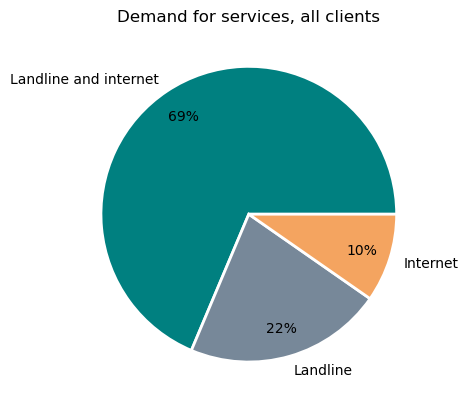

In [89]:
(data['services']
 .value_counts()
 .plot(
     kind='pie',
     autopct='%1.0f%%',
     pctdistance=0.8,
     wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
     colors=['teal', 'lightslategrey', 'sandybrown', 'mediumseagreen', 'skyblue', 'lightpink', 'olivedrab'],
     title='Demand for services, all clients',
     ylabel=''
 )
);

The most common option is landline usage in conjunction with internet usage.

For further analysis we should take a look at types of subscription among all clients.

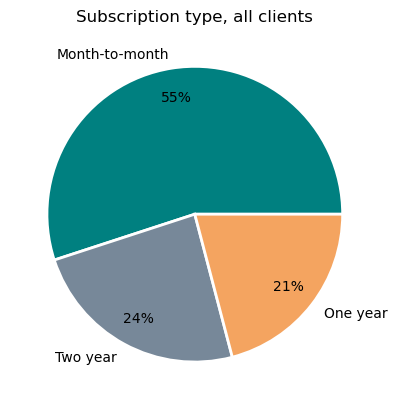

In [91]:
(data['type']
 .value_counts()
 .plot(
     kind='pie',
     autopct='%1.0f%%',
     pctdistance=0.8,
     wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
     colors=['teal', 'lightslategrey', 'sandybrown'],
     title='Subscription type, all clients',
     ylabel=''
 )
);

Mostly clients prefer to pay on a monthly basis.

Continue by drawing a plot of target's distribution.

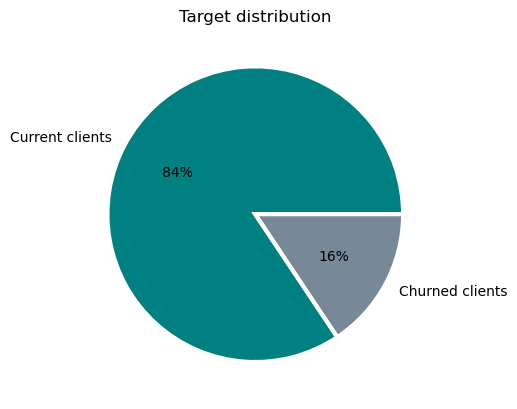

In [93]:
(data['outflow']
 .value_counts()
 .plot(
     kind='pie',
     labels=['Current clients', 'Churned clients'],
     autopct='%1.0f%%',
     wedgeprops={'linewidth': 3, 'edgecolor': 'white'},
     colors=['teal', 'lightslategrey'],
     title='Target distribution',
     ylabel=''
 )
);

Target is imbalanced, so it would be necessary to solve this issue before models training.

Hypotheses that would be checked further:
- churned clients mainly pay more than remaining clients
- churned customers mainly pay on a monthly basis
- churned customers mainly use services less than 1 year

### 4.2 Testing hypotheses

#### 4.2.1 Hypothesis №1. Сhurned clients mainly pay more than remaining clients

Start by drawing box plots based on total and monthly costs.

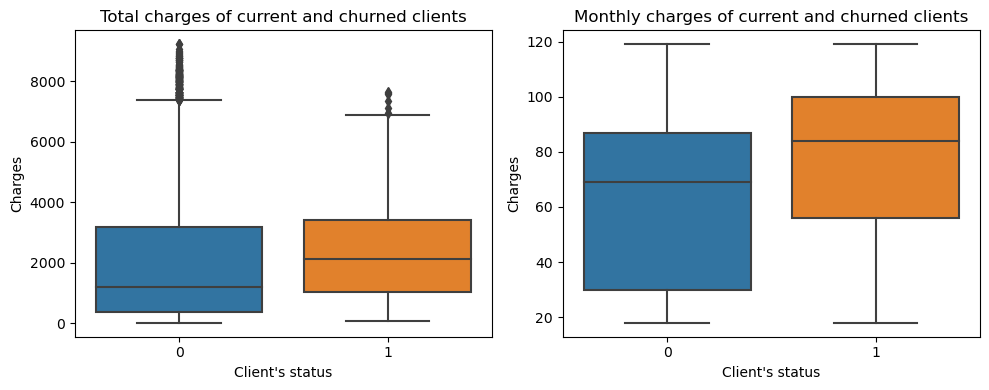

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_params = {
    'xlabel': 'Client\'s status',
    'ylabel': 'Charges'
}

sns.boxplot(
    x='outflow', 
    y='total_charges', 
    data=data,
    ax=axes[0]
).set(**plot_params)

sns.boxplot(
    x='outflow', 
    y='monthly_charges', 
    data=data,
    ax=axes[1]
).set(**plot_params)

axes[0].set_title('Total charges of current and churned clients')
axes[1].set_title('Monthly charges of current and churned clients')
plt.tight_layout();

Median expenses of churned customers are higher than for remaining customers. At the same time, the first quartile is also higher for churned customers. We will build a plot of monthly expenses by subscription period.

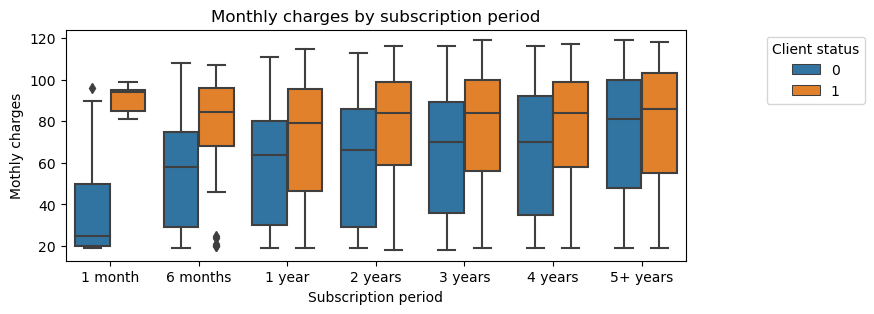

In [101]:
plt.figure(figsize=(8,3))
sns.boxplot(
    x='period', 
    y='monthly_charges', 
    data=data,
    hue='outflow',
    hue_order=[0, 1]
)
plt.title('Monthly charges by subscription period')
plt.xlabel('Subscription period')
plt.ylabel('Mothly charges')
plt.legend(title='Client status', loc='upper right', bbox_to_anchor=(1.3, 1.0));

We see that the same picture is typical for all subscription periods.
We can say that our hypothesis was confirmed: mainly clients with higher costs terminate their contracts.

#### 4.2.2 Hypothesis №2. Mainly clients paying monthly terminate contract

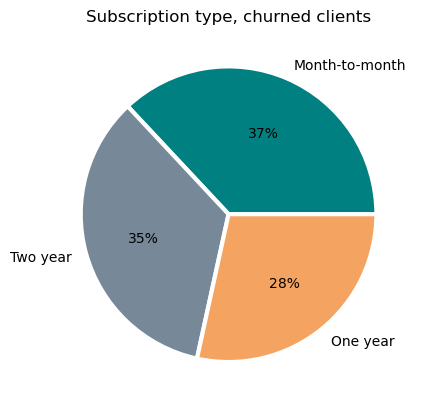

In [104]:
(data[data['outflow'] == 1]['type']
 .value_counts()
 .plot(
     kind='pie',
     autopct='%1.0f%%',
     wedgeprops={'linewidth': 3, 'edgecolor': 'white'},
     colors=['teal', 'lightslategrey', 'sandybrown'],
     title='Subscription type, churned clients',
     ylabel=''
 )
);

Indeed, customers paying monthly are majority in churned clients. However, customers paying every 2 years account almost the same number. We could assume that the hypothesis was confirmed, but with a clarification about clients with a two-year subscription type.

#### 4.2.3 Hypothesis №3. Mainly churned clients are relatively new clients

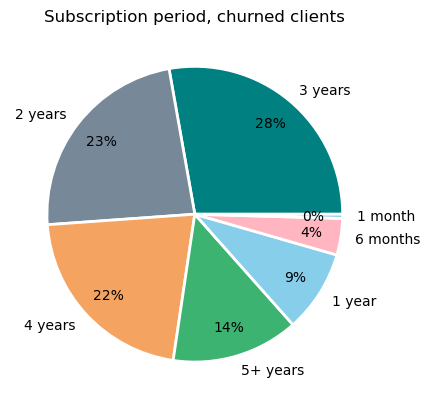

In [107]:
(data[data['outflow'] == 1]['period']
 .value_counts()
 .plot(
     kind='pie',
     autopct='%1.0f%%',
     pctdistance=0.8,
     wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
     colors=['teal', 'lightslategrey', 'sandybrown', 'mediumseagreen', 'skyblue', 'lightpink', 'skyblue'],
     title='Subscription period, churned clients',
     ylabel=''
 )
);

The hypothesis was not confirmed; customers churn mainly in the period of 2-3 years. And clients with suscription period up to 1 year and 5+ years turned out to be equally loyal and leave less often than others. Now we could remove the temporary column with the subscription period.

In [109]:
data.drop(columns=['period'], inplace=True)

### 4.3 Сorrelation analysis

Start by checking data correlation, including multicollinearity. Since the data is mostly categorical, we would use phik matrix.

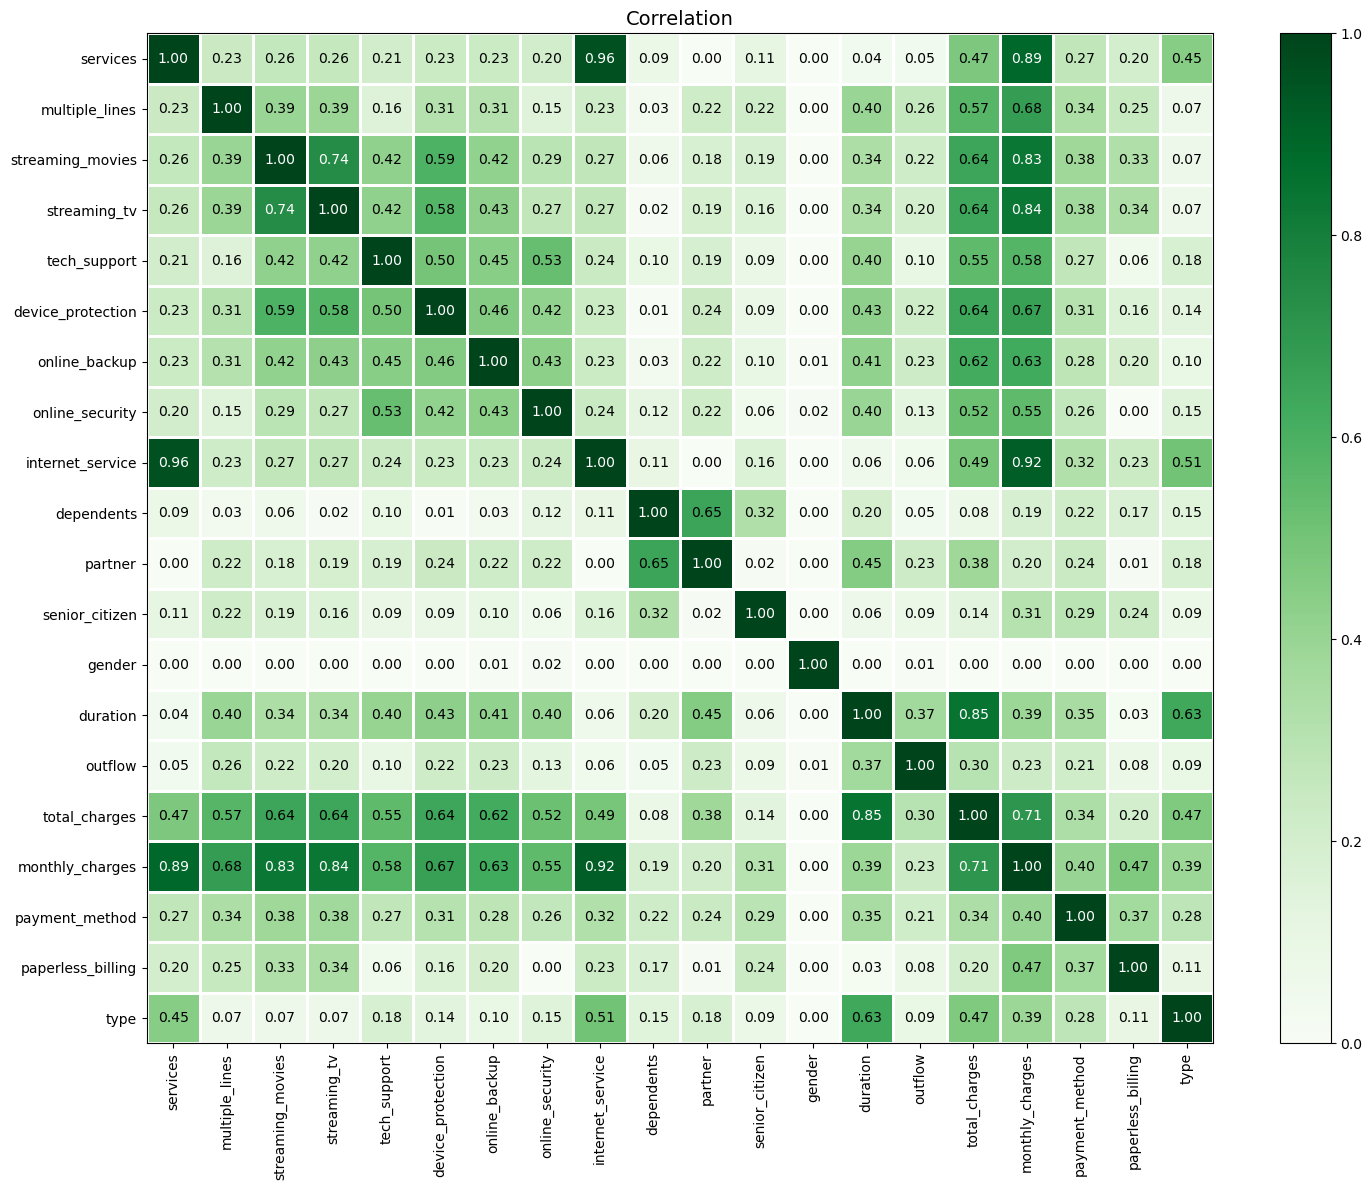

In [112]:
interval_cols=['monthly_charges', 'total_charges', 'duration']
phik_overview = data.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Greens', 
                        title='Correlation', 
                        fontsize_factor=1.0, 
                        figsize=(15, 12))

The `gender` feature has no correlation with other features. Also `age`, `dependents` and `billing method` have very low or almost no correlation with the target. `Internet_service` has a very strong correlation with `monthly_charges` and `services`, multicorrelation can interfere with model training. Proceed by checking statistical significance of correlation.

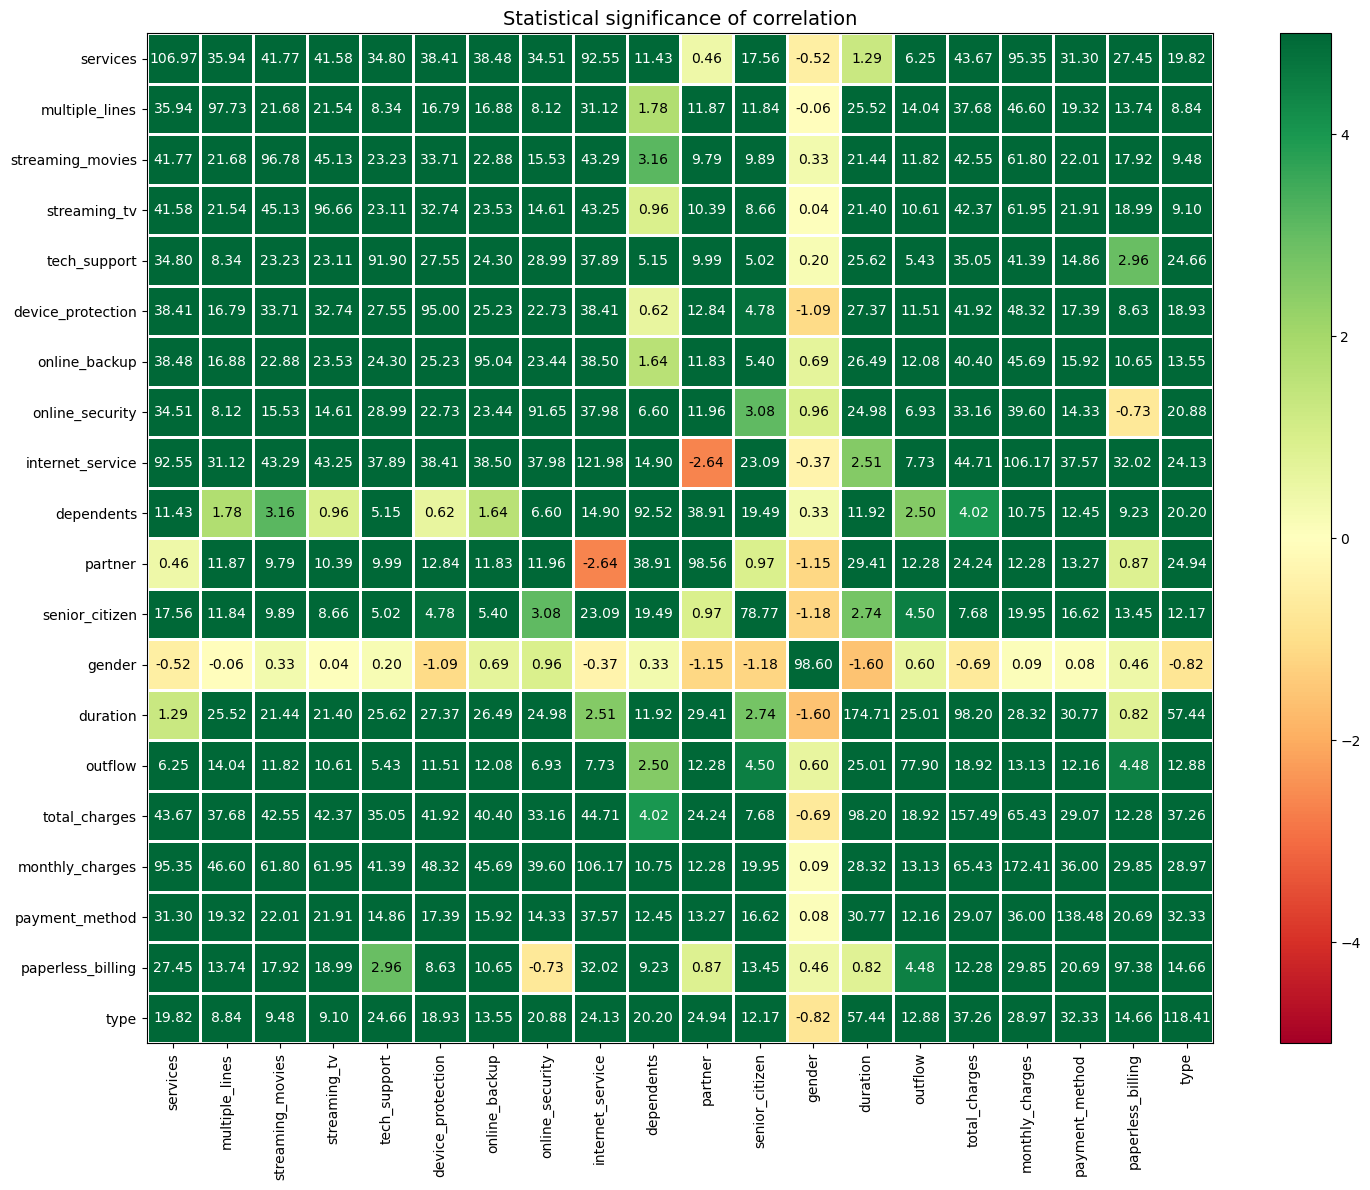

In [114]:
significance_overview = data.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title='Statistical significance of correlation', 
                        usetex=False, fontsize_factor=1.0, figsize=(15, 12))

We would remove above-mentioned features due to low statistical significance, and `internet_service` as well due to multicollinearity.

In [116]:
df_new = data.drop(['gender', 'internet_service', 'dependents', 'senior_citizen', 'paperless_billing'], axis=1)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   type               7043 non-null   object
 1   payment_method     7043 non-null   object
 2   monthly_charges    7043 non-null   int64 
 3   total_charges      7043 non-null   int64 
 4   outflow            7043 non-null   int64 
 5   duration           7043 non-null   int64 
 6   partner            7043 non-null   object
 7   online_security    7043 non-null   object
 8   online_backup      7043 non-null   object
 9   device_protection  7043 non-null   object
 10  tech_support       7043 non-null   object
 11  streaming_tv       7043 non-null   object
 12  streaming_movies   7043 non-null   object
 13  multiple_lines     7043 non-null   object
 14  services           7043 non-null   object
dtypes: int64(4), object(11)
memory usage: 1.1+ MB


Removal was successful.

**Intermediate conclusion:** 18% of operator's revenue is formed by churned clients. The majority of current clients have been served by the company for less than 1 year and use both internet and landline communication services. 55% of clients pay on a monthly basis. “Churned client portrait”: client with higher monthly and total costs for services, paying monthly or once every 2 years and being served by the company for 2-3 years. For further training low-correlated features were removed, as well as features showing multicollinearity.

<a id='preparation'></a>

## 5. Feature engineering

Proceed by splitting data frame into train and test sets.

In [122]:
features_train, features_test, target_train, target_test = train_test_split(
    df_new.drop('outflow', axis=1), df_new['outflow'], test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=df_new['outflow'])

In [123]:
features_train.shape

(5282, 14)

In [124]:
features_test.shape

(1761, 14)

Splitting was successful and in correct proportion. Continue by scaling and encoding features. We would create several transformers for different models.

In [126]:
num_features = ['monthly_charges', 'total_charges', 'duration']
cat_features = ['type', 'payment_method', 'services', 'partner', 'online_security',
                'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
               'streaming_movies', 'multiple_lines']

lr_transformer = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
    (StandardScaler(), num_features),
    remainder='passthrough',
    verbose_feature_names_out=False
)

transformer = make_column_transformer(
    (OrdinalEncoder(), cat_features),
    remainder='passthrough',
    verbose_feature_names_out=False
)

Proceed by creating a function that would select hyperparameters and train model using cross-validation. The target imbalance would be taken into account by using pipeline and SMOTE. Since target is imbalanced, plain accuracy metric is not suitable, so we would use ROC-AUC, which measures the model’s ability to distinguish between negative and positive classes.

In [128]:
def find_best_model(model, param_grid, transformer=transformer):
    """Select hyperparameters and train model."""
    pipeline = IMBPipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('model', model)
    ])
    param_grid_prefix = {'model__' + key: value for key, value in param_grid.items()}
    grid_search = GridSearchCV(pipeline, param_grid_prefix, scoring='roc_auc', n_jobs=-1, cv=5)
    
    features_train_transf = transformer.fit_transform(features_train)
    grid_search.fit(features_train_transf, target_train)
    
    print(f'Model with best hyperparameters: {grid_search.best_params_},\n'
          f'The best ROC-AUC metric: {grid_search.best_score_:.3f}')
    return grid_search.best_score_

**Intermediate conclusion:** data is prepared for training taking into account models' specifics and presence of categorical features. A function has been written for selecting hyperparameters with handling target imbalance and using cross-validation, pipeline and transformer.

<a id='learning'></a>

## 6. Model selection, training and evaluation

Start by training 4 models - RandomForestClassifier, Logistic Regression, LGBMClassifier and CatBoostClassifier.

Here and further below we would limit parameters as model's best result, so cells run much faster.

In [133]:
rf = find_best_model(RandomForestClassifier(random_state=RANDOM_STATE),
                     param_grid={'max_depth': range(8, 9),
                                 'n_estimators': range(19, 20),
                                 'min_samples_split': [4],
                                 }
                    )

Model with best hyperparameters: {'model__max_depth': 8, 'model__min_samples_split': 4, 'model__n_estimators': 19},
The best ROC-AUC metric: 0.814


Logistic regression shows worse result - 0.77. 

In [135]:
lr = find_best_model(LogisticRegression(random_state=RANDOM_STATE),
                     param_grid = {'penalty': ['l1', 'l2'],
                                   'C': [0.01, 0.1, 1, 10],
                                   'solver': ['liblinear'],
                                   'multi_class': ['ovr']
                                  },
                     transformer=lr_transformer
                    )

Model with best hyperparameters: {'model__C': 0.1, 'model__multi_class': 'ovr', 'model__penalty': 'l1', 'model__solver': 'liblinear'},
The best ROC-AUC metric: 0.769


The best result for LGBMClassifier is 0.89.

In [137]:
lgbm = find_best_model(LGBMClassifier(random_state=RANDOM_STATE, verbosity=-1),
                       param_grid = {
                           'learning_rate': [0.3],
                           'objective': ['binary'],
                           'min_child_samples': [3]
                       }
                      )

Model with best hyperparameters: {'model__learning_rate': 0.3, 'model__min_child_samples': 3, 'model__objective': 'binary'},
The best ROC-AUC metric: 0.889


In [138]:
cbc = find_best_model(CatBoostClassifier(verbose=False, random_state=RANDOM_STATE),
                     param_grid = {
                         'n_estimators': [2100],
                         'learning_rate': [0.2],
                         'max_depth': [2]
                     }
                     )

Model with best hyperparameters: {'model__learning_rate': 0.2, 'model__max_depth': 2, 'model__n_estimators': 2100},
The best ROC-AUC metric: 0.920


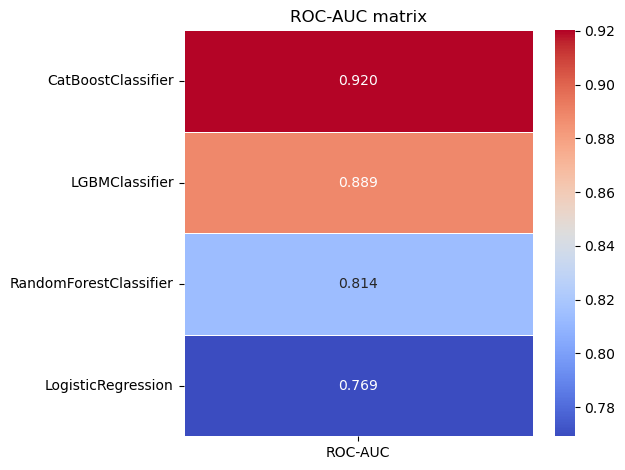

In [139]:
auc_roc_results = pd.DataFrame(
    [cbc, lgbm, rf, lr],
    index=['CatBoostClassifier', 'LGBMClassifier', 'RandomForestClassifier', 'LogisticRegression'],
    columns=['ROC-AUC']
)

sns.heatmap(auc_roc_results, annot=True, fmt='.3f', linewidths=0.5, cmap='coolwarm')
plt.gca().set_title('ROC-AUC matrix')
plt.tight_layout();

CatBoostClassifier shows the best result among other models - 0.92. We would train CatBoostClassifier model with fitted hyperparameters on the entire train data without cross-validation.

In [141]:
param_grid = {
    'n_estimators': 2100,
    'learning_rate': 0.2,
    'max_depth': 2,
    'auto_class_weights': 'Balanced'
}
catboost = CatBoostClassifier(verbose=False, **param_grid, random_seed=RANDOM_STATE)

features_train_transf = pd.DataFrame(
    transformer.fit_transform(features_train),
    columns=transformer.get_feature_names_out()
)

catboost.fit(features_train_transf, target_train);

Resume by defining important features during model's training.

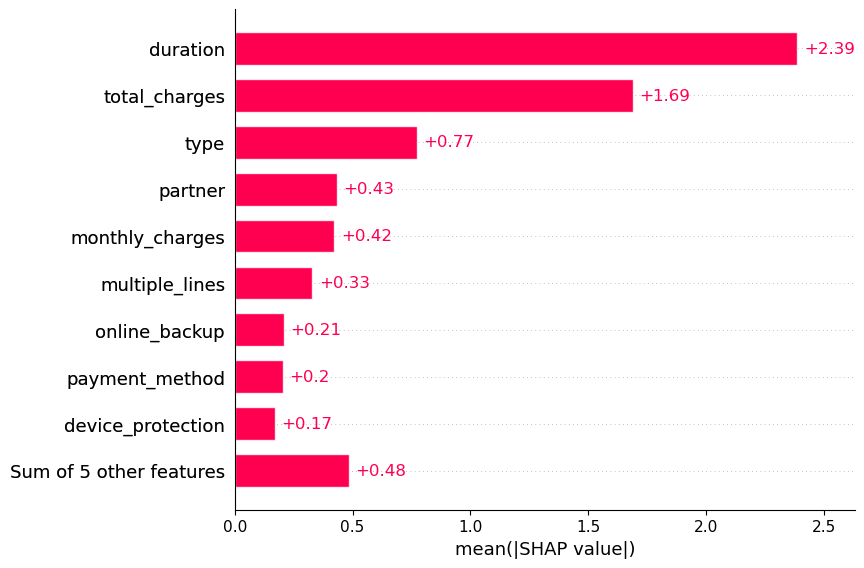

In [143]:
explainer = shap.Explainer(catboost)
shap_values = explainer(features_train_transf)
shap.plots.bar(shap_values)

The most important features during training are duration, total charges and type of payment.

**Intermediate conclusion:** we trained 4 models - RandomForestClassifier, Logistic Regression, LGBMClassifier and CatBoostClassifier. CatBoostClassifier showed the best result with hyperparameters: n_estimators=2100, learning_rate=0.2, max_depth=2, auto_class_weights=Balanced. The most important features during training were duration, total charges and type of payment.

<a id='testing'></a>

## 7. Testing model

Proceed by transforming test data and testing model.

In [149]:
features_test_transf = transformer.transform(features_test)

In [150]:
probabilities_test = catboost.predict_proba(features_test_transf)
probabilities_test_one = probabilities_test[:, 1]
test_roc_auc = roc_auc_score(target_test, probabilities_test_one)
round(test_roc_auc, 3)

0.927

Model showed ROC-AUC metrics 0.927 on test data. The result is sufficient to customer's requirement. Additionally we would calculate an `accuracy` indicator and construct an error matrix to see the absolute values.

In [152]:
predictions_test = catboost.predict(features_test_transf)
round(balanced_accuracy_score(target_test, predictions_test), 2)

0.85

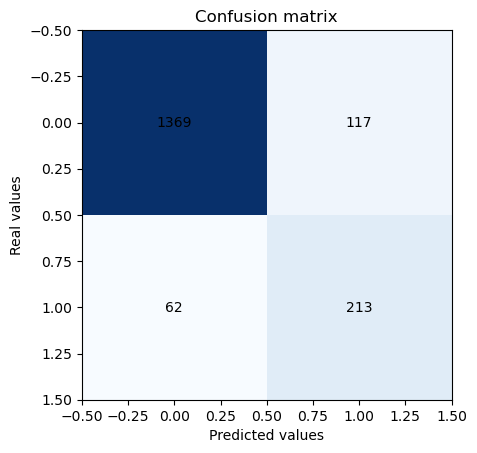

In [153]:
conf_m = confusion_matrix(target_test, predictions_test)
plt.imshow(conf_m, cmap='Blues', interpolation='nearest')

for i in range(conf_m.shape[0]):
    for j in range(conf_m.shape[1]):
        plt.text(j, i, str(conf_m[i, j]), ha='center', va='center', color='black')
        
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.title('Confusion matrix');

Model gives 61 false negative and 115 false positive answers on test data. In other words model forecasted that 61 clients would not terminate their contract, however some measures should be taken to hold them. And at the same time model misforecasted that 115 would leave. Therefore model's precision is lower than it's recall.

Proceed by drawing ROC-curve on test data.

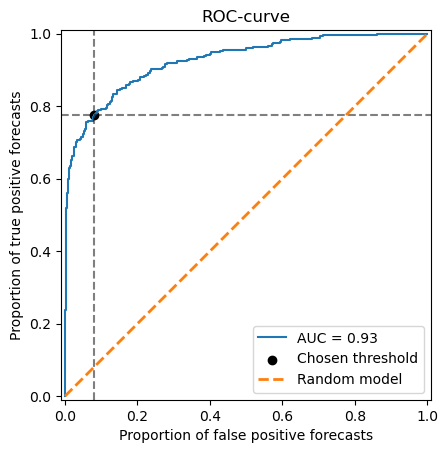

In [155]:
fpr, tpr, _ = roc_curve(target_test, probabilities_test_one)
fpr_value = conf_m[0, 1]/(conf_m[0, 1] + conf_m[0, 0])
recall = recall_score(target_test, predictions_test)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=test_roc_auc).plot()

plt.scatter(fpr_value, recall, color='k', label='Chosen threshold')
plt.axvline(fpr_value, linestyle='--', color='k', alpha=0.5)
plt.axhline(recall, linestyle='--', color='k', alpha=0.5)

plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random model')

plt.xlabel('Proportion of false positive forecasts')
plt.ylabel('Proportion of true positive forecasts')
plt.legend()
plt.title('ROC-curve');

The graph marks threshold between proportion of false positive predictions and proportion of true positive predictions. Since ideally the proportion of false positive predictions should tend to 0, and true positive ones - to 1, at this point it was possible to achieve a balance of indicators: 0.08 and 0.78, respectively.
Telecom provider's satisfaction with the result would depend on ability to retain customers, including a size of allocated budget: on the one hand, more false positives answers mean the provider would waste more resources on retaining more customers. On the other hand, fewer false negatives answers could be better because there are fewer unexpected losses among customers.

Apparently our result is better than random model's result. We would also confirm this by comparing it with constant model.

In [157]:
dummy_model = DummyClassifier(random_state=RANDOM_STATE, strategy='most_frequent')
dummy_model.fit(features_train, target_train)
dummy_predictions = dummy_model.predict_proba(features_test)[:, 1]
roc_auc_score(target_test, dummy_predictions)

0.5

Our model shows better result than constant model.

**Intermediate conclusion:** CatBoostClassifier model showed ROC-AUC as 0.93 on test data, which satisfies clients requirements and better than constant model. Accuracy is 0.85. Model's precision is lower than it's recall. 
Level of provider's satisfaction would depend on ability to retain customers, including a size of allocated budget: on the one hand, more false positives answers mean that provider would waste more resources on retaining more customers. On the other hand, fewer false negatives answers are better because there are fewer unexpected customer losses. If it is needed, it would be possible to shift the balance point in one direction or another.

<a id='conclusion'></a>

## 8. Summary

**The target of analysis** was to predict customers churn. Anonymized customer data and information about services were provided by telecom provider. Based on the model’s predictions, it is planned to distribute promotional codes and special conditions to retain customers identified by model. The provider expects ROC-AUC metric to be at least 0.85.

Brief overview of conducted work:
- preprocessing stage (new features were introduced, data was checked for duplicates, missing values were handled)
- “portrait of churned client” has been drawn up
- statistical significance of correlation was assessed
- hyperparameters were selected using cross-validation for 4 models using gradient boosting
- best model's performance was tested

**General conclusions:**
- churned customers make 18% of telecom provider’s income
- most of the current clients have been served by the operator for less than 1 year
- the vast majority of clients use both internet and landline services
- 55% of clients pay on a monthly basis

*CatBoostClassifier showed the best result* with hyperparameters n_estimators=2100, learning_rate=0.2, max_depth=2, auto_class_weights=Balanced.

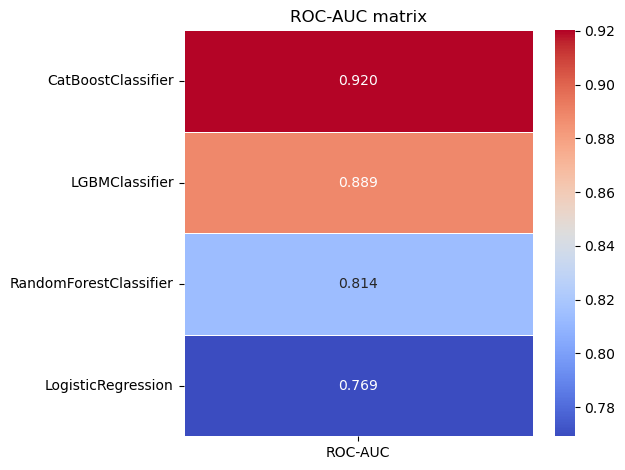

**The model's ROC-AUC metric meets client's requirements on test data - 0.93**. The model produced 61 false negative and 115 false positive responses. So the model predicted that 61 clients would not break the contract, but in fact it was worth taking measures to retain them. And at the same time, it incorrectly predicted that 115 clients might leave.

The success of such model would depend on the provider's ability to retain customers, including a size of an allocated budget: more false positive answers mean the operator would waste more resources on retaining more customers. On the other hand, fewer false negative answers are better because there are fewer unexpected losses among customers.

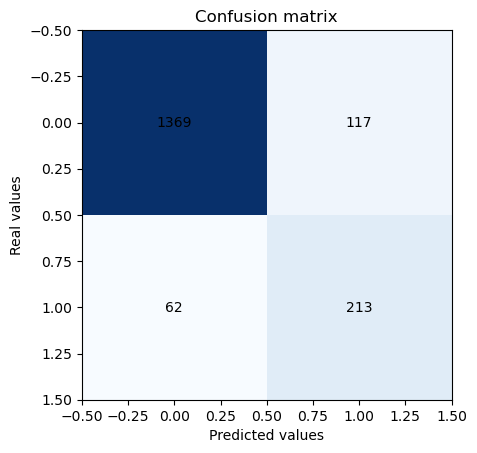

For model's training such features as gender, age, dependents, type of internet connection and use of electronic receipts were not used. **The most important features for the model's training were duration of maintenance, amount of total and monthly expenses and type of payment**.

The significance of these features could be explained by their important part in “portrait of churned client”. **“Portrait of churned client”: clients with higher monthly/total costs, paying monthly or once every 2 years and being served by the company for 2-3 years**.

**Conclusions:**
- no dependencies were found between specific service's usage and churned customers, while cost's influence is quite significant. Therefore, a customer retention strategy through cost reductions/promotional codes/special conditions could demonstrate a positive effect
- resulting model shows much better results than a model that would randomly select clients to send promotional codes. It is recommended to implement the resulting model, since it would be more effective. For example, not all high-cost customers decided to switch telecom provider
- during preprocessing some missing values were identified for clients being new on the date of data upload. The operator is advised to check what may have caused the technical error and whether it affects data management